In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read Data
df = pd.read_csv('/content/drive/MyDrive/dataset/training.1600000.processed.noemoticon.csv', header=None, encoding='latin')
df.columns = ['label', 'id', 'date', 'query', 'user', 'tweet']

# Data reduction
df = df.drop(['id', 'date', 'query', 'user'], axis=1)

### **Preprocessing**

In [4]:
# Dictionary mapping numeric labels to corresponding sentiment categories
labels_dict = {0: 'Negative', 2: 'Neutral', 4: 'Positive'}

# Function to convert numeric label to sentiment category using the labels_dict
def convert_labels(label):
    return labels_dict[label]

# Applying the convert_labels function to the 'label' column of the DataFrame (assuming df is defined)
df.label = df.label.apply(lambda x: convert_labels(x))

# Displaying the modified DataFrame with converted sentiment labels
df


,label,tweet
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,is upset that he can't update his Facebook by ...
2,Negative,@Kenichan I dived many times for the ball. Man...
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,Positive,Just woke up. Having no school is the best fee...
1599996,Positive,TheWDB.com - Very cool to hear old Walt interv...
1599997,Positive,Are you ready for your MoJo Makeover? Ask me f...
1599998,Positive,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Creating a list of English stopwords
stop_words = stopwords.words('english')

# Creating a SnowballStemmer object for stemming words in English
stemmer = SnowballStemmer('english')

# Regular expression pattern to match and remove special characters, URLs, and mentions
# '@\S+' matches mentions (e.g., @username)
# 'https?:\S+' matches URLs starting with http or https
# 'http?:\S' matches URLs starting with http (without the 's')
# '[^A-Za-z0-9]+' matches any non-alphanumeric characters
punctuations_and_dummies = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
# Function to preprocess a tweet by removing special characters, converting to lowercase, and removing stopwords
def preprocess(tweet, will_be_stemmed=True):
    # Remove special characters, URLs, and mentions using the defined pattern
    tweet = re.sub(punctuations_and_dummies, ' ', str(tweet).lower()).strip()

    # Initialize an empty list to store tokens
    tokens = []

    # Iterate through each token in the preprocessed tweet
    for token in tweet.split():
        # Check if the token is not in the list of stopwords
        if token not in stop_words:
            # If stemming is requested, apply stemming using SnowballStemmer
            if will_be_stemmed:
                tokens.append(stemmer.stem(token))
            else:
                # If no stemming, add the token as it is to the list
                tokens.append(token)

    # Join the processed tokens to form the final preprocessed tweet
    return " ".join(tokens)

# Applying the preprocess function to the 'tweet' column of the DataFrame (assuming df is defined)
df.tweet = df.tweet.apply(lambda tw: preprocess(tw))


In [7]:
# Remove 0 length tweets
df = df[df.iloc[:,1].astype(str).str.len()!=0]

In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df, test_size=0.2, random_state=7)
print('Training Data', len(train_data), 'Test Data', len(test_data))

train_data.head(10)

Training Data 1273862 Test Data 318466


,label,tweet
927561,Positive,thank
810082,Positive,shakin money tree head back car busi
1153331,Positive,tasmania okay chat ya later
988182,Positive,yeah 100 tab storm towel raider awesom
543405,Negative,happi mari asleep gotta start laundri b4 wake ...
22855,Negative,want go citi rain gotta homework 2
483675,Negative,sit home bore x
667231,Negative,miss ami card
1370823,Positive,dinner hubbi two us 10 coupo
94439,Negative,know prob run around


### **Model-1 Countvectorized Naive Bayes**

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
first_K_tweets = train_data['tweet']

# Creating a CountVectorizer object with English stopwords removed
vectorizer = CountVectorizer(stop_words='english')

# Fitting the vectorizer on the first K tweets and transforming them into a document-term matrix
vec = vectorizer.fit_transform(first_K_tweets)

# Displaying the feature names (words) in the vocabulary learned by the vectorizer
# This provides a dictionary of words corresponding to the columns in the document-term matrix
vectorizer.get_feature_names_out()


array(['00', '000', '0000', ..., 'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz',
       'zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz'],
      dtype=object)

In [12]:
test_vec = vectorizer.transform(test_data['tweet'])

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
# Creating an instance of the Multinomial Naive Bayes classifier
classifier_mnb = MultinomialNB()
# Training the classifier using the document-term matrix (vec) and corresponding labels from the 'label' column
classifier_mnb.fit(vec, train_data['label'])

MultinomialNB()

In [27]:
# Using the trained Multinomial Naive Bayes classifier to predict labels for the test set
y_prediction = classifier_mnb.predict(test_vec)

# Calculating the accuracy score of the classifier on the test set
score = (classifier_mnb.score(test_vec, test_data['label'])) * 100

# Printing the accuracy score as a percentage
print('CountVectorizer Naive Bayes score = ' + str(score) + '%')


CountVectorizer Naive Bayes score = 76.08159112746729%


Confusion matrix for Multinomial Naive Bayes model
[[122668  36825]
 [ 39347 119626]]


<Axes: >

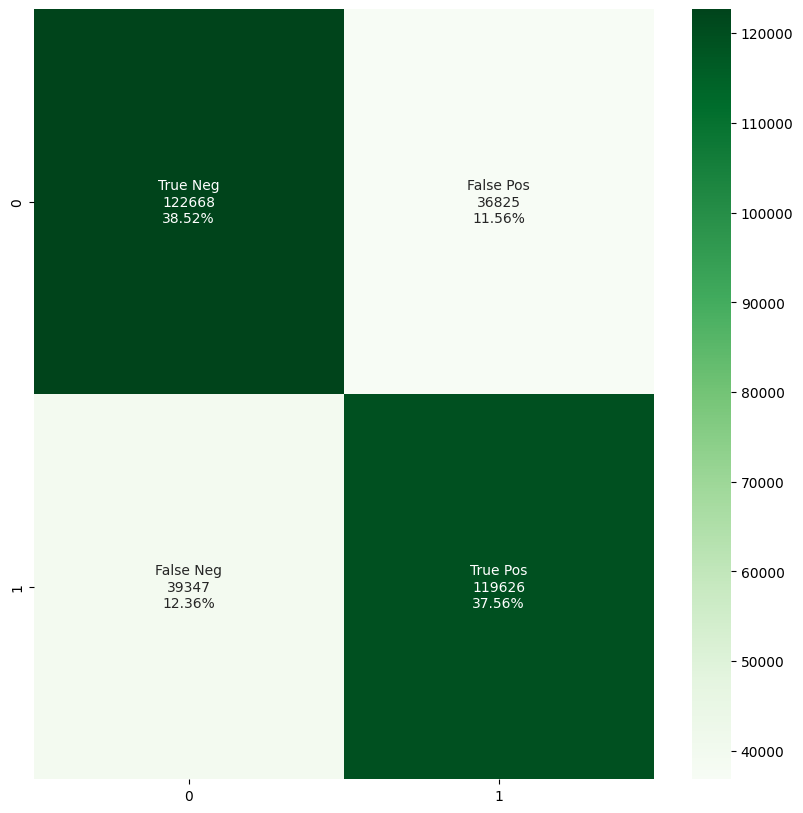

In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
print("Confusion matrix for Multinomial Naive Bayes model")
cf_matrix = confusion_matrix(test_data['label'], y_prediction)
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

In [29]:
print("Classification report for Multinomial Naive Bayes")
print(classification_report(test_data['label'], y_prediction))

Classification report for Multinomial Naive Bayes
              precision    recall  f1-score   support

    Negative       0.76      0.77      0.76    159493
    Positive       0.76      0.75      0.76    158973

    accuracy                           0.76    318466
   macro avg       0.76      0.76      0.76    318466
weighted avg       0.76      0.76      0.76    318466



### **Model-2 Naive Bayes using TF-IDF vectorizer**

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Creating a TfidfVectorizer object with English stopwords removed
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Learn vocabulary from tweets
tfidf_vec = tfidf_vectorizer.fit(first_K_tweets)

# Vocabulary
# vectorizer.vocabulary_

In [31]:
tfidf_vec = tfidf_vectorizer.transform(first_K_tweets)

In [32]:
# Transforming the test set tweets into TF-IDF matrix using the same vectorizer
tfidf_test_vec = tfidf_vectorizer.transform(test_data['tweet'])

In [33]:
tfidf_classifier = MultinomialNB()
tfidf_classifier.fit(tfidf_vec, train_data['label'])

MultinomialNB()

In [34]:
# Using the trained classifier to predict labels for the test set
y_prediction = tfidf_classifier.predict(tfidf_test_vec)
score = (tfidf_classifier.score(tfidf_test_vec, test_data['label'])) * 100
print("tf-idf Näive_Bayes score = " + str(score) + "%")

tf-idf Näive_Bayes score = 75.42657614941626%


Confusion matrix for Multinomial Naive Bayes using TF-IDF vectorizer
[[121417  38076]
 [ 40182 118791]]


<Axes: >

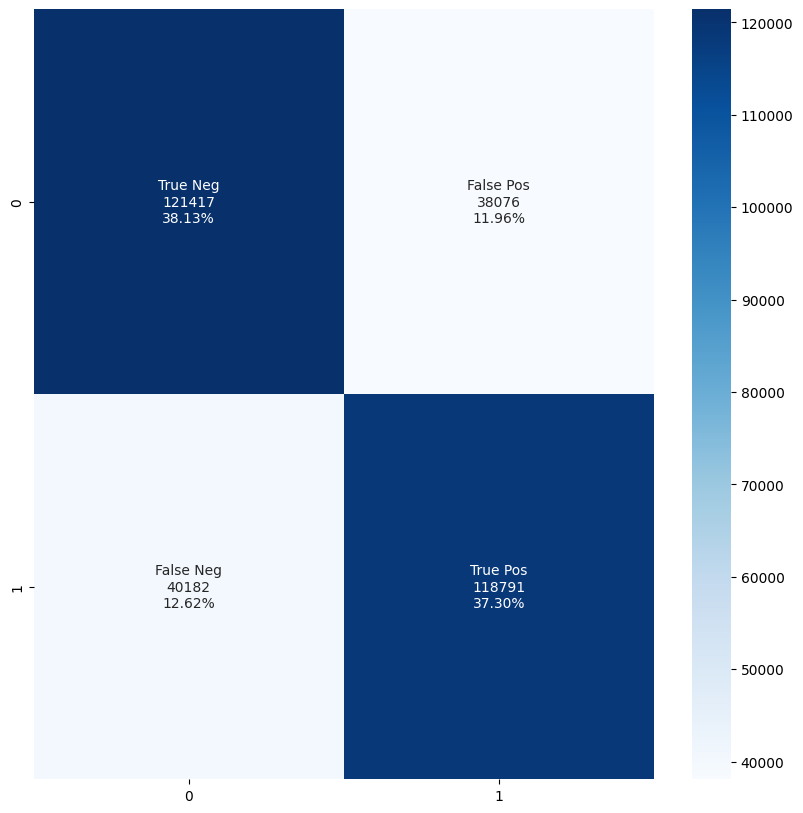

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
print("Confusion matrix for Multinomial Naive Bayes using TF-IDF vectorizer")
cf_matrix = confusion_matrix(test_data['label'], y_prediction)
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [36]:
print("Classification report for Multinomial Naive Bayes using TF-Idf vectorizer" )
print(classification_report(test_data['label'], y_prediction))

Classification report for Multinomial Naive Bayes using TF-Idf vectorizer
              precision    recall  f1-score   support

    Negative       0.75      0.76      0.76    159493
    Positive       0.76      0.75      0.75    158973

    accuracy                           0.75    318466
   macro avg       0.75      0.75      0.75    318466
weighted avg       0.75      0.75      0.75    318466



### **Model-3 Support vector machine classifier using TF-IDF**

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

# Assuming train_data['tweet'] is a list of strings
first_K_tweets = train_data['tweet']

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english')
vec = vectorizer.fit_transform(first_K_tweets)

# Linear SVM classifier
classifier_svm = LinearSVC()
classifier_svm.fit(vec, train_data['label'])



LinearSVC()

In [38]:
y_prediction = classifier_svm.predict(test_vec)
score = (classifier_svm.score(test_vec, test_data['label'])) * 100
print('Linear SVM score= '+ str(score) + '%')

Linear SVM score= 76.77774079493572%


Confusion matrix for SVM classifier
[[126825  32668]
 [ 41287 117686]]


<Axes: >

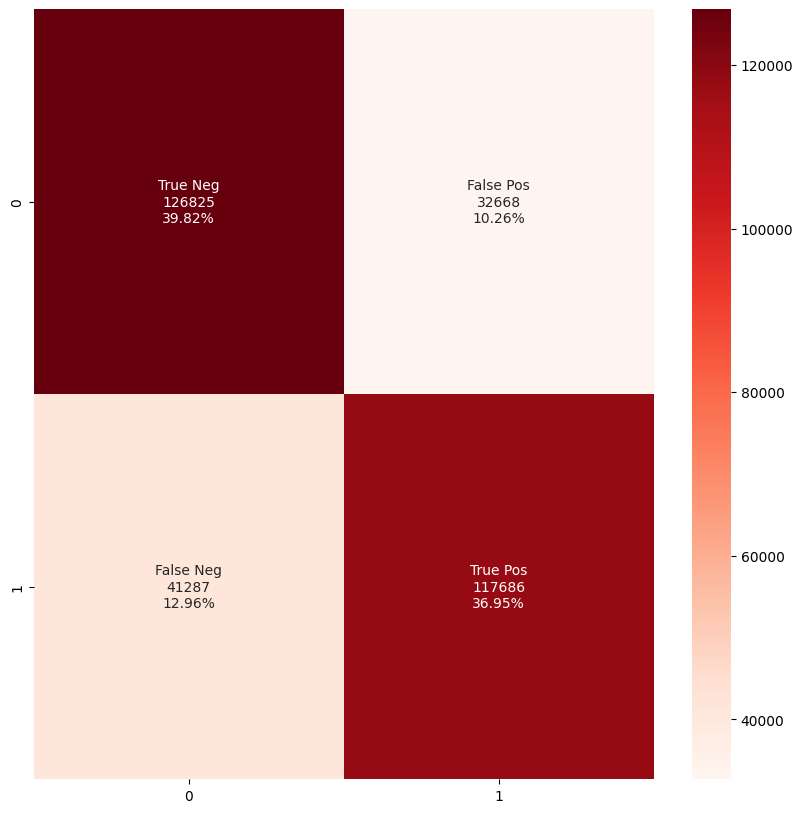

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
print("Confusion matrix for SVM classifier")
cf_matrix = confusion_matrix(test_data['label'], y_prediction)
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Reds')

In [40]:
print("Classification report for SVM classifier")
print(classification_report(test_data['label'], y_prediction))

Classification report for SVM classifier
              precision    recall  f1-score   support

    Negative       0.75      0.80      0.77    159493
    Positive       0.78      0.74      0.76    158973

    accuracy                           0.77    318466
   macro avg       0.77      0.77      0.77    318466
weighted avg       0.77      0.77      0.77    318466



### **Model-4 CountVectorized Support Vector Machine**

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC

# Assuming train_data['tweet'] is a list of strings
first_K_tweets = train_data['tweet']

# CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
vec = vectorizer.fit_transform(first_K_tweets)

# Linear SVM classifier
countvec_svm = LinearSVC()
countvec_svm.fit(vec, train_data['label'])


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [19]:
y_prediction = countvec_svm.predict(test_vec)
score = (countvec_svm.score(test_vec, test_data['label'])) * 100
print('Linear SVM score= '+ str(score) + '%')

Linear SVM score= 76.31489703767436%


Confusion matrix for SVM classifier
[[117946  41547]
 [ 33882 125091]]


<Axes: >

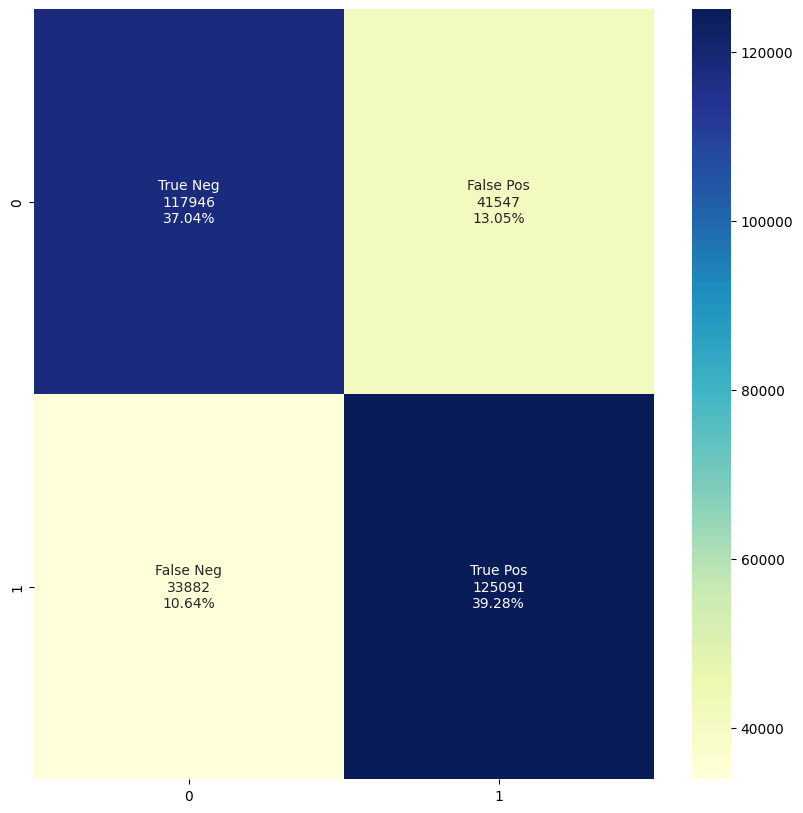

In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
print("Confusion matrix for SVM classifier")
cf_matrix = confusion_matrix(test_data['label'], y_prediction)
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='YlGnBu')

In [17]:
print("Classification report for SVM classifier")
print(classification_report(test_data['label'], y_prediction))

Classification report for SVM classifier
              precision    recall  f1-score   support

    Negative       0.78      0.74      0.76    159493
    Positive       0.75      0.79      0.77    158973

    accuracy                           0.76    318466
   macro avg       0.76      0.76      0.76    318466
weighted avg       0.76      0.76      0.76    318466



### **Model-5 Logistic Regression using N-Gram on Countvectorizer**

In [16]:
X_train=train_data["tweet"]
y_train=train_data["label"]
X_test=test_data["tweet"]
y_test=test_data["label"]

In [41]:
# Creating a CountVectorizer object with a minimum document frequency of 5 and considering unigrams and bigrams

vect = CountVectorizer(min_df=5, ngram_range=(1, 2)).fit(X_train)

# Getting the total number of unique features (words and word pairs) in the vocabulary
num_features = len(vect.get_feature_names_out())

In [42]:
import pickle
with open('vect.pkl', 'wb') as file:
    pickle.dump(vect, file)

In [43]:
# Transforming the training data (X_train) into a document-term matrix using the fitted CountVectorizer
X_train_vectorized = vect.transform(X_train)

# Transforming the test data (X_test) into a document-term matrix using the same CountVectorizer
X_test_vectorized = vect.transform(X_test)


In [44]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train_vectorized,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [45]:
predictions = model_lr.predict(vect.transform(X_test))

In [46]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_test, predictions)*100
print('Logistic Regression using N-gram score = ',score,"%")

Logistic Regression using N-gram score =  78.58170102930924 %


Confusion Matrix:
[[121129  38364]
 [ 29846 129127]]


<Axes: >

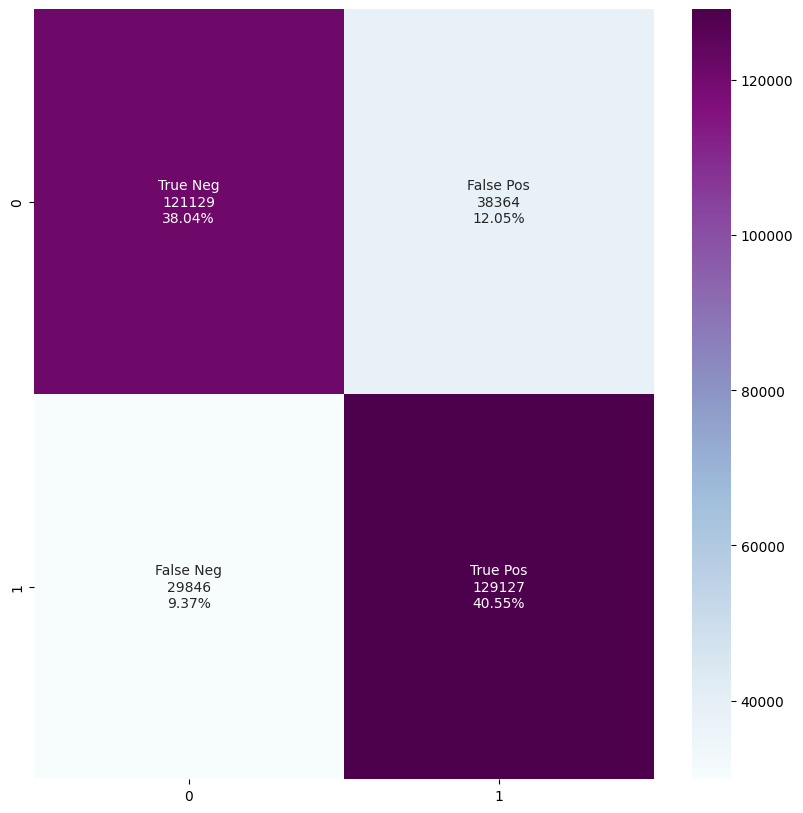

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model_lr.predict(X_test_vectorized)

cf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuPu')

In [48]:
from sklearn.metrics import classification_report
target_names = ['negative', 'positive']
prinreport = classification_report(y_test, y_pred,target_names=target_names)
print("Classification Report:\n", prinreport)


Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.76      0.78    159493
    positive       0.77      0.81      0.79    158973

    accuracy                           0.79    318466
   macro avg       0.79      0.79      0.79    318466
weighted avg       0.79      0.79      0.79    318466



### **Model-6 Logistic Regression using N-gram on TF-IDF**

In [21]:
# Creating a CountVectorizer object with a minimum document frequency of 5 and considering unigrams and bigrams
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(min_df=5, ngram_range=(1, 2)).fit(X_train)

# Getting the total number of unique features (words and word pairs) in the vocabulary
num_features = len(vect.get_feature_names_out())
import pickle
with open('vect.pkl', 'wb') as file:
    pickle.dump(vect, file)

# Transforming the training data (X_train) into a document-term matrix using the fitted CountVectorizer
X_train_vectorized = vect.transform(X_train)

# Transforming the test data (X_test) into a document-term matrix using the same CountVectorizer
X_test_vectorized = vect.transform(X_test)
from sklearn.linear_model import LogisticRegression
tfidf_lr = LogisticRegression()
tfidf_lr.fit(X_train_vectorized,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [22]:
predictions = tfidf_lr.predict(vect.transform(X_test))
from sklearn.metrics import accuracy_score

score = accuracy_score(y_test, predictions)*100
print('Logistic Regression using N-gram score = ',score,"%")

Logistic Regression using N-gram score =  79.1312102390836 %


Confusion Matrix:
[[123559  35934]
 [ 30526 128447]]


<Axes: >

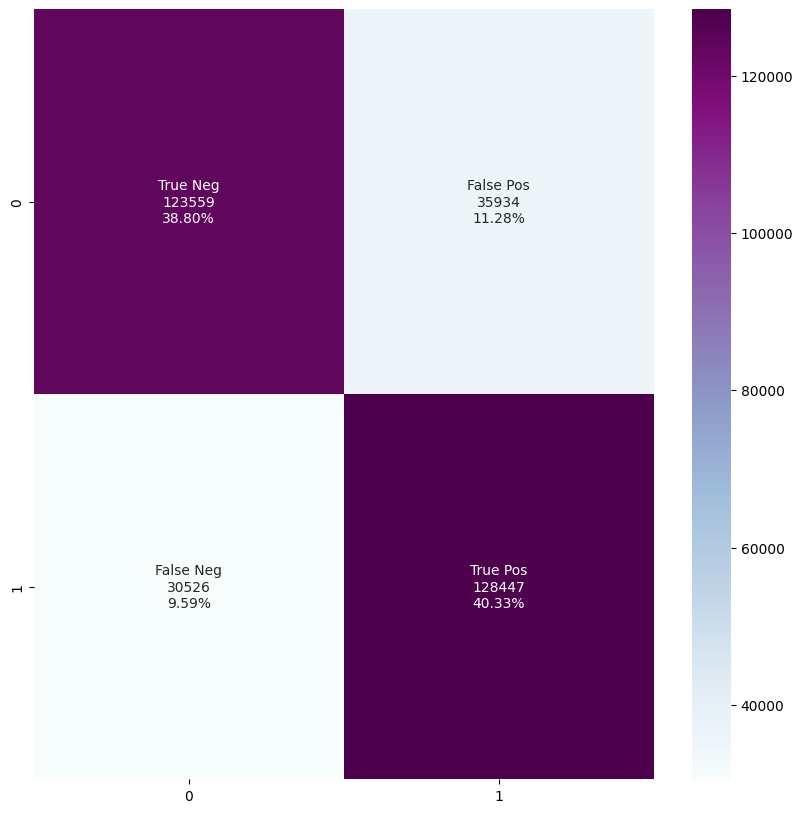

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = tfidf_lr.predict(X_test_vectorized)

cf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuPu')

In [24]:
from sklearn.metrics import classification_report
target_names = ['negative', 'positive']
prinreport = classification_report(y_test, y_pred,target_names=target_names)
print("Classification Report:\n", prinreport)


Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.77      0.79    159493
    positive       0.78      0.81      0.79    158973

    accuracy                           0.79    318466
   macro avg       0.79      0.79      0.79    318466
weighted avg       0.79      0.79      0.79    318466



### **Bagging Classifier**

In [49]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
#Using a BaggingClassifier with a base estimator being a VotingClassifier that combines predictions from various base models.
#The base models include Multinomial Naive Bayes, TF-IDF Naive Bayes, Logistic Regression with n-gram features, and Support Vector Machine.

bagging_model = BaggingClassifier(
    base_estimator=VotingClassifier(estimators=[
        ('naive_bayes_mnb', classifier_mnb),
        ('naive_bayes_tfidf', tfidf_classifier),
        ('logistic_regression_n_gram_mnb', model_lr),
        ('logistic_regression_n_gram_tfidf',tfidf_lr),
        ('svm_tfidf', classifier_svm),
        ('svm_mnb',countvec_svm)
    ], voting='hard'),
    n_estimators=1,
    random_state=7
)

# Fit the bagging model on the training data
bagging_model.fit(X_train_vectorized, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modul

BaggingClassifier(base_estimator=VotingClassifier(estimators=[('naive_bayes_mnb',
                                                               MultinomialNB()),
                                                              ('naive_bayes_tfidf',
                                                               MultinomialNB()),
                                                              ('logistic_regression_n_gram_mnb',
                                                               LogisticRegression()),
                                                              ('logistic_regression_n_gram_tfidf',
                                                               LogisticRegression()),
                                                              ('svm_tfidf',
                                                               LinearSVC()),
                                                              ('svm_mnb',
                                                               LinearSVC())]),
                  n_estimators=1, random_state=7)

In [50]:
# Make predictions on the test set
y_pred = bagging_model.predict(X_test_vectorized)

# Evaluate the performance of the bagging model
print("Bagging Accuracy:", accuracy_score(y_test, y_pred))
print("Bagging Classification Report:\n", classification_report(y_test, y_pred))

Bagging Accuracy: 0.7773137477784128
Bagging Classification Report:
               precision    recall  f1-score   support

    Negative       0.79      0.76      0.77    159493
    Positive       0.77      0.79      0.78    158973

    accuracy                           0.78    318466
   macro avg       0.78      0.78      0.78    318466
weighted avg       0.78      0.78      0.78    318466



Confusion Matrix:
[[121485  38008]
 [ 32910 126063]]


<Axes: >

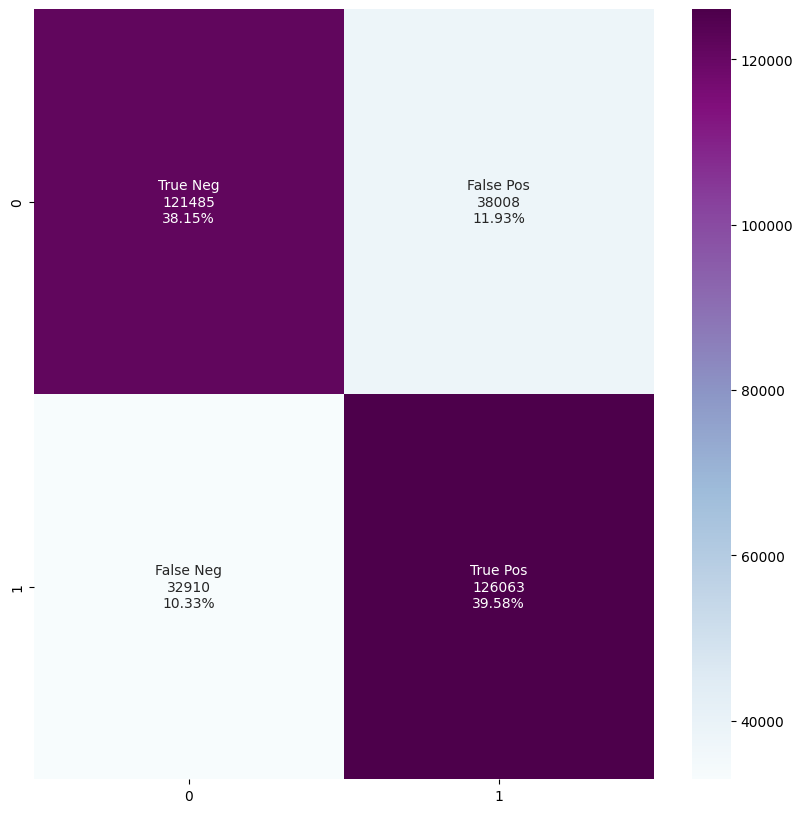

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cf_matrix)

plt.figure(figsize = (10,10))
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='BuPu')

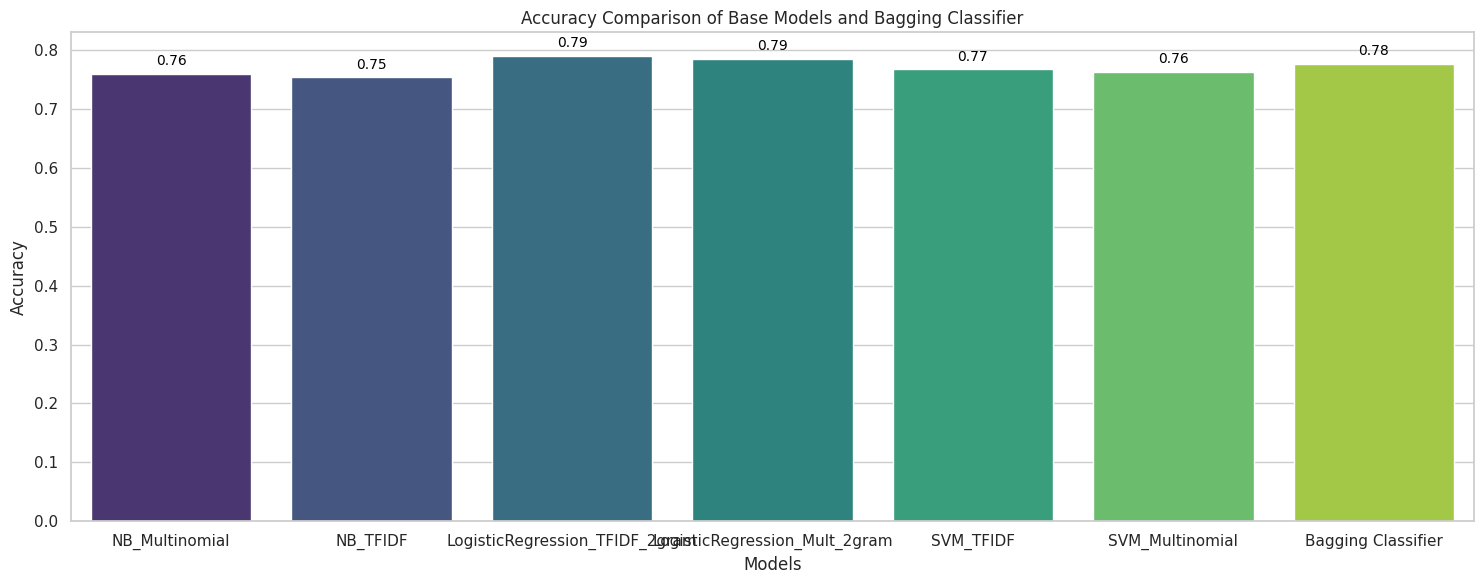

In [53]:
import seaborn as sns
import numpy as np

# Assuming you have already trained and evaluated the base models and BaggingClassifier
# Get the accuracy scores for each model
accuracy_scores = [0.7608,0.7542,0.7913,0.7858,0.7677,0.7631,0.7773]

# Model names for labeling the bar graph
model_names = ['NB_Multinomial', 'NB_TFIDF', 'LogisticRegression_TFIDF_2gram','LogisticRegression_Mult_2gram', 'SVM_TFIDF','SVM_Multinomial', 'Bagging Classifier']

# Set Seaborn style
sns.set(style="whitegrid")

# Plotting the bar graph using Seaborn
plt.figure(figsize=(15, 6))
ax = sns.barplot(x=model_names, y=accuracy_scores, palette="viridis")

# Adding accuracy scores on top of the bars
for i, score in enumerate(accuracy_scores):
    ax.text(i, score + 0.01, f'{score:.2f}', ha='center', va='bottom', color='black', fontsize=10)

# Setting labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Base Models and Bagging Classifier')

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
input_data = (["Nice job thanks"])
input_data_reshaped = vect.transform(input_data)
prediction = bagging_model.predict(input_data_reshaped)
print(prediction[0])


Positive


In [ ]:
import pickle
filename = 'MLmodel.sav'
pickle.dump( bagging_model, open(filename, 'wb'))

In [ ]:
# loading the saved model
loaded_model = pickle.load(open('MLmodel.sav', 'rb'))